# 实验4：决策树与集成学习（随机森林）

本 Notebook 实现了：

1. **自实现决策树分类器（CART，基尼指数）**，并在 Adult 数据集上测试；
2. **自实现随机森林分类器（Bagging + 随机特征子集）**；
3. 对比 `sklearn` 中对应模型的性能；
4. 通过 **可视化** 展示不同模型与参数设置下的分类效果差异。


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline


## 一、自实现决策树分类器（CART）

下面实现一个简单的 CART 决策树分类器，使用 **基尼指数 (Gini)** 作为划分标准，支持：

- 连续与离散特征（通过数值化实现）；
- 设置最大深度、最小划分样本数、最小叶子节点样本数等超参数。


In [2]:
class MyDecisionTreeClassifier:
    """一个简单的 CART 决策树实现（仅用于分类）"""
    def __init__(
        self,
        max_depth=None,
        min_samples_split=2,
        min_samples_leaf=1,
        min_impurity_decrease=0.0
    ):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        self.n_classes_ = None
        self.n_features_ = None
        self.tree_ = None

    class Node:
        def __init__(self, gini, num_samples, num_samples_per_class,
                     predicted_class):
            self.gini = gini
            self.num_samples = num_samples
            self.num_samples_per_class = num_samples_per_class
            self.predicted_class = predicted_class
            self.feature_index = None
            self.threshold = None
            self.left = None
            self.right = None

    def _gini(self, y):
        m = y.size
        if m == 0:
            return 0.0
        _, counts = np.unique(y, return_counts=True)
        p = counts / m
        return 1.0 - np.sum(p ** 2)

    def _best_split(self, X, y):
        m, n = X.shape
        if m < self.min_samples_split:
            return None, None

        best_gini = 1.0
        best_idx, best_thr = None, None
        parent_gini = self._gini(y)

        for idx in range(n):
            sorted_idx = np.argsort(X[:, idx])
            X_sorted = X[sorted_idx, idx]
            y_sorted = y[sorted_idx]

            num_left = np.zeros(self.n_classes_, dtype=int)
            _, counts_total = np.unique(y_sorted, return_counts=True)
            num_right = counts_total.copy()

            for i in range(1, m):
                c = y_sorted[i - 1]
                num_left[c] += 1
                num_right[c] -= 1

                if X_sorted[i] == X_sorted[i - 1]:
                    continue

                if i < self.min_samples_leaf or (m - i) < self.min_samples_leaf:
                    continue

                gini_left = 1.0 - np.sum((num_left[:] / i) ** 2)
                gini_right = 1.0 - np.sum((num_right[:] / (m - i)) ** 2)
                gini = (i * gini_left + (m - i) * gini_right) / m

                if gini < best_gini and (parent_gini - gini) >= self.min_impurity_decrease:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (X_sorted[i] + X_sorted[i - 1]) / 2.0

        return best_idx, best_thr

    def _grow_tree(self, X, y, depth):
        num_samples_per_class = np.bincount(y, minlength=self.n_classes_)
        predicted_class = np.argmax(num_samples_per_class)
        node = self.Node(
            gini=self._gini(y),
            num_samples=y.size,
            num_samples_per_class=num_samples_per_class,
            predicted_class=predicted_class,
        )

        if (self.max_depth is not None and depth >= self.max_depth) or \
           node.gini == 0.0 or \
           y.size < self.min_samples_split:
            return node

        idx, thr = self._best_split(X, y)
        if idx is None:
            return node

        indices_left = X[:, idx] <= thr
        X_left, y_left = X[indices_left], y[indices_left]
        X_right, y_right = X[~indices_left], y[~indices_left]

        if y_left.size == 0 or y_right.size == 0:
            return node

        node.feature_index = idx
        node.threshold = thr
        node.left = self._grow_tree(X_left, y_left, depth + 1)
        node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        self.n_classes_ = len(np.unique(y))
        self.n_features_ = X.shape[1]
        self.tree_ = self._grow_tree(X, y, depth=0)
        return self

    def _predict_inputs(self, inputs):
        node = self.tree_
        while node.left is not None and node.right is not None:
            if inputs[node.feature_index] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class

    def predict(self, X):
        X = np.asarray(X)
        return np.array([self._predict_inputs(inputs) for inputs in X])


## 二、Adult 数据集加载与预处理

Adult 数据集是一个经典的收入预测数据集，目标是预测 `income` 是否大于 `50K`。

> 注意：本单元使用 `fetch_openml` 从网络下载数据，首次运行需要联网。


In [3]:
# 1) 加载 Adult 数据集
adult = fetch_openml(name="adult", version=2, as_frame=True)
X = adult.data.copy()
y = adult.target.copy()

print("原始数据维度:", X.shape)
X.head()


原始数据维度: (48842, 14)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States


In [4]:
# 2) 特征预处理：
#    - 类别特征：LabelEncoder 编码；缺失值填为 "Unknown"；
#    - 数值特征：缺失值填为中位数。

X_processed = X.copy()
encoders_X = {}

for col in X_processed.columns:
    if X_processed[col].dtype == "object" or str(X_processed[col].dtype) == "category":
        X_processed[col] = X_processed[col].astype("category")
        if "Unknown" not in X_processed[col].cat.categories:
            X_processed[col] = X_processed[col].cat.add_categories("Unknown")
        X_processed[col] = X_processed[col].fillna("Unknown")
        le = LabelEncoder()
        X_processed[col] = le.fit_transform(X_processed[col])
        encoders_X[col] = le
    else:
        X_processed[col] = X_processed[col].astype(float)
        X_processed[col] = X_processed[col].fillna(X_processed[col].median())

# 3) 标签处理
y = y.astype("category")
le_y = LabelEncoder()
y_encoded = le_y.fit_transform(y)

# 4) 划分训练 / 测试集
X_train, X_test, y_train, y_test = train_test_split(
    X_processed.values, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)


Train shape: (39073, 14)  Test shape: (9769, 14)


## 三、自实现决策树 vs Sklearn 决策树

在相同的超参数设置下，对比两种实现的测试集准确率，并给出可视化柱状图。


In [5]:
# 训练自实现决策树
my_tree = MyDecisionTreeClassifier(
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5
)
my_tree.fit(X_train, y_train)
y_pred_my_tree = my_tree.predict(X_test)
acc_my_tree = accuracy_score(y_test, y_pred_my_tree)
print(f"MyDecisionTree Test Accuracy: {acc_my_tree:.4f}")

# Sklearn 决策树
sk_tree = DecisionTreeClassifier(
    criterion="gini",
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
sk_tree.fit(X_train, y_train)
y_pred_sk_tree = sk_tree.predict(X_test)
acc_sk_tree = accuracy_score(y_test, y_pred_sk_tree)
print(f"Sklearn DecisionTree Test Accuracy: {acc_sk_tree:.4f}")


MyDecisionTree Test Accuracy: 0.8586
Sklearn DecisionTree Test Accuracy: 0.8590


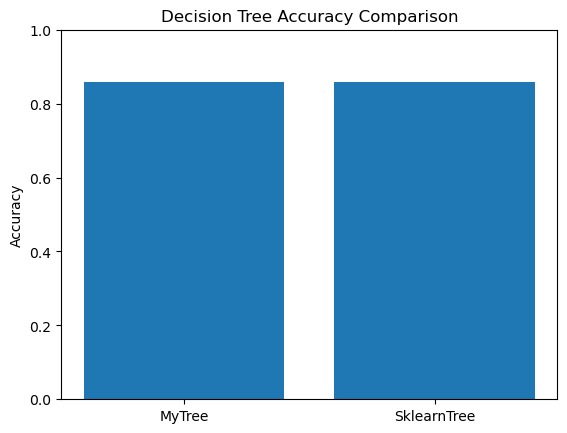

In [6]:
# 可视化：对比两个决策树的测试准确率
plt.figure()
models = ["MyTree", "SklearnTree"]
accs = [acc_my_tree, acc_sk_tree]
x = np.arange(len(models))
plt.bar(x, accs)
plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.title("Decision Tree Accuracy Comparison")
plt.ylim(0, 1)
plt.show()


## 四、自实现随机森林分类器

在自实现决策树的基础上，构造随机森林：

- 采用 **Bootstrap 自助采样** 构建多个训练子集；
- 每棵树在划分结点时仅考虑一个随机的特征子集（`max_features`）；
- 最终预测使用多棵树的 **多数表决**。


In [7]:
class MyRandomForestClassifier:
    """简单随机森林实现：Bagging + 随机特征子集"""
    def __init__(
        self,
        n_estimators=10,
        max_depth=None,
        max_features="sqrt",
        bootstrap=True,
        min_samples_split=2,
        min_samples_leaf=1,
        min_impurity_decrease=0.0,
        random_state=None,
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.min_impurity_decrease = min_impurity_decrease
        self.random_state = random_state

        self.trees_ = []
        self.features_indices_ = []
        self.n_classes_ = None

    def _get_n_features_subsample(self, n_features):
        if self.max_features is None:
            return n_features
        if isinstance(self.max_features, int):
            return max(1, min(self.max_features, n_features))
        if self.max_features == "sqrt":
            return max(1, int(np.sqrt(n_features)))
        if self.max_features == "log2":
            return max(1, int(np.log2(n_features)))
        return n_features

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        n_samples, n_features = X.shape
        self.n_classes_ = len(np.unique(y))
        self.trees_ = []
        self.features_indices_ = []

        rng = np.random.RandomState(self.random_state)
        n_sub_features = self._get_n_features_subsample(n_features)

        for i in range(self.n_estimators):
            if self.bootstrap:
                indices = rng.randint(0, n_samples, n_samples)
            else:
                indices = np.arange(n_samples)
            X_boot = X[indices]
            y_boot = y[indices]

            feat_idx = rng.choice(n_features, n_sub_features, replace=False)
            X_boot_sub = X_boot[:, feat_idx]

            tree = MyDecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                min_impurity_decrease=self.min_impurity_decrease,
            )
            tree.fit(X_boot_sub, y_boot)

            self.trees_.append(tree)
            self.features_indices_.append(feat_idx)

        return self

    def predict(self, X):
        X = np.asarray(X)
        n_samples = X.shape[0]
        all_preds = np.zeros((n_samples, self.n_estimators), dtype=int)

        for i, (tree, feat_idx) in enumerate(zip(self.trees_, self.features_indices_)):
            all_preds[:, i] = tree.predict(X[:, feat_idx])

        y_pred = np.zeros(n_samples, dtype=int)
        for i in range(n_samples):
            counts = np.bincount(all_preds[i], minlength=self.n_classes_)
            y_pred[i] = np.argmax(counts)
        return y_pred

    def score(self, X, y):
        return accuracy_score(y, self.predict(X))


### 4.1 自实现随机森林 vs Sklearn 随机森林


In [8]:
# 自实现随机森林
my_rf = MyRandomForestClassifier(
    n_estimators=30,
    max_depth=10,
    max_features="sqrt",
    bootstrap=True,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42
)
my_rf.fit(X_train, y_train)
y_pred_my_rf = my_rf.predict(X_test)
acc_my_rf = accuracy_score(y_test, y_pred_my_rf)
print(f"MyRandomForest Test Accuracy: {acc_my_rf:.4f}")

# Sklearn 随机森林
sk_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    max_features="sqrt",
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
sk_rf.fit(X_train, y_train)
y_pred_sk_rf = sk_rf.predict(X_test)
acc_sk_rf = accuracy_score(y_test, y_pred_sk_rf)
print(f"Sklearn RandomForest Test Accuracy: {acc_sk_rf:.4f}")


MyRandomForest Test Accuracy: 0.8099
Sklearn RandomForest Test Accuracy: 0.8619


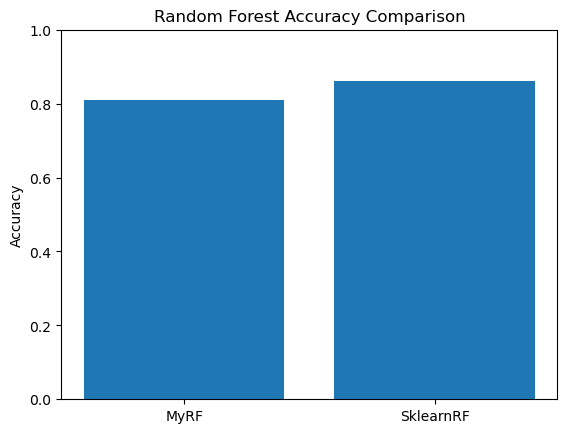

In [9]:
# 可视化：对比两个随机森林的测试准确率
plt.figure()
models = ["MyRF", "SklearnRF"]
accs = [acc_my_rf, acc_sk_rf]
x = np.arange(len(models))
plt.bar(x, accs)
plt.xticks(x, models)
plt.ylabel("Accuracy")
plt.title("Random Forest Accuracy Comparison")
plt.ylim(0, 1)
plt.show()


### 4.2 基学习器数量与特征子集策略对性能的影响

下面固定其他参数，改变：

- 随机森林中树的数量 `n_estimators`；
- 特征子集策略 `max_features`（取 "sqrt" 与 "log2"）；

观察其对测试集准确率的影响，并通过折线图展示。


In [10]:
n_estimators_list = [1, 3, 5, 10, 20, 30]
acc_list_sqrt = []
acc_list_log2 = []

for n_est in n_estimators_list:
    rf_sqrt = MyRandomForestClassifier(
        n_estimators=n_est,
        max_depth=10,
        max_features="sqrt",
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    )
    rf_sqrt.fit(X_train, y_train)
    acc_list_sqrt.append(accuracy_score(y_test, rf_sqrt.predict(X_test)))

    rf_log2 = MyRandomForestClassifier(
        n_estimators=n_est,
        max_depth=10,
        max_features="log2",
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    )
    rf_log2.fit(X_train, y_train)
    acc_list_log2.append(accuracy_score(y_test, rf_log2.predict(X_test)))

print("n_estimators:", n_estimators_list)
print("sqrt acc    :", acc_list_sqrt)
print("log2 acc    :", acc_list_log2)


n_estimators: [1, 3, 5, 10, 20, 30]
sqrt acc    : [0.8110349063363701, 0.8129798341693111, 0.8310983724024977, 0.8002866209438019, 0.8185075237997748, 0.8099088954857201]
log2 acc    : [0.8110349063363701, 0.8129798341693111, 0.8310983724024977, 0.8002866209438019, 0.8185075237997748, 0.8099088954857201]


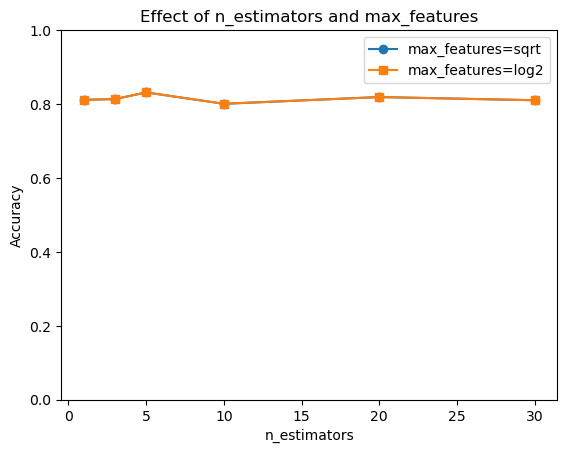

In [11]:
# 可视化：不同 n_estimators 与 max_features 下的准确率曲线
plt.figure()
plt.plot(n_estimators_list, acc_list_sqrt, marker="o", label="max_features=sqrt")
plt.plot(n_estimators_list, acc_list_log2, marker="s", label="max_features=log2")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("Effect of n_estimators and max_features")
plt.ylim(0, 1)
plt.legend()
plt.show()


## 五、小结

通过本实验我们：

- 从零实现了 CART 决策树与基于它的随机森林算法；
- 在 Adult 数据集上验证了模型性能；
- 使用可视化对比了不同模型与参数设置对分类性能的影响。

你可以在此基础上继续：

- 调整树的深度、最小样本数等超参数，观察过拟合与欠拟合现象；
- 尝试不同的数据集；
- 增加特征重要性分析等内容，丰富实验报告。
